## Getting the consequences of variants in a gene

Suppose you have a gene of interest (e.g. `APOE` in humans) and you're interested in finding variants on that gene in the EVA. In particular, you want to know about variants with non-synonymous consequences, which can affect the protein product of the gene. This notebook will walk you through how to get that data using the EVA API (with an assist from Ensembl).

For reference, here is the documentation for all the APIs we will use:

* [Ensembl API](https://rest.ensembl.org/)
* [EVA Variant Info API](https://www.ebi.ac.uk/eva/webservices/rest/swagger-ui.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
gene_name = 'APOE'

First we need the location (chromosome, start and end coordinates) of the gene of interest. We'll use Ensembl's API for this, but of course there are many other ways.

In [3]:
xrefs_url = f'https://rest.ensembl.org/xrefs/symbol/homo_sapiens/{gene_name}?content-type=application/json'
response = requests.get(xrefs_url)
ensembl_id = response.json()[0]['id']

lookup_url = f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json'
response = requests.get(lookup_url)
gene_info = response.json()

chrom = gene_info['seq_region_name']
start = gene_info['start']
end = gene_info['end']

In [4]:
# We can use the assembly and species names from Ensembl to query EVA, just modified slightly
genus, species = gene_info['species'].split('_')
taxonomy_code = genus[0] + species
assembly_code = gene_info['assembly_name'].lower()

Next, we query the EVA API for all variants in this region, for the species and assembly in question.

In [5]:
# The limit parameter sets the maximum number of results to return.
# If there are more than the limit you will have to page through the results; in our case 1000 is enough.
segments_url = f'https://www.ebi.ac.uk/eva/webservices/rest/v1/segments/' \
               f'{chrom}:{start}-{end}/variants?species={taxonomy_code}_{assembly_code}' \
               f'&limit=1000'

response = requests.get(segments_url)
variants = response.json()['response'][0]['result']

The response can be really large as it includes all the source data contained in the EVA for a given variant, including all samples in all studies. Since we are looking for consequences, let's just look at the `annotation` field.

In [6]:
variants[0]['annotation']

{'chromosome': '19',
 'start': 44905804,
 'end': 44905804,
 'vepVersion': '86',
 'vepCacheVersion': '86',
 'consequenceTypes': [{'geneName': 'APOE',
   'ensemblGeneId': 'ENSG00000130203',
   'ensemblTranscriptId': 'ENST00000446996',
   'strand': '+',
   'biotype': 'protein_coding',
   'cDnaPosition': 14,
   'aaChange': '-',
   'codon': '-',
   'soTerms': [{'soName': '5_prime_UTR_variant',
     'soAccession': 'SO:0001623'}]},
  {'geneName': 'TOMM40',
   'ensemblGeneId': 'ENSG00000130204',
   'ensemblTranscriptId': 'ENST00000405636',
   'strand': '+',
   'biotype': 'protein_coding',
   'aaChange': '-',
   'codon': '-',
   'soTerms': [{'soName': 'downstream_gene_variant',
     'soAccession': 'SO:0001632'}]},
  {'geneName': 'APOE',
   'ensemblGeneId': 'ENSG00000130203',
   'ensemblTranscriptId': 'ENST00000485628',
   'strand': '+',
   'biotype': 'retained_intron',
   'cDnaPosition': 9,
   'aaChange': '-',
   'codon': '-',
   'soTerms': [{'soName': 'non_coding_transcript_exon_variant',
    

We're interested in non-synonymous variants, so we'll filter the results for those which have some annotation which is not `synonymous_variant`.

In [7]:
nonsynonymous_variants = []
for v in variants:
    if 'annotation' in v:
        consequences = v['annotation']['consequenceTypes']
        for c in consequences:
            # Could also look only for consequences on the APOE gene
            if 'synonymous_variant' not in {s['soName'] for s in c['soTerms']}:
                nonsynonymous_variants.append(v)
                break

Now that we have this data, we can start to explore it a bit. For example let's just see where the nonsynonymous variants tend to be in the gene, as compared to the synonymous ones.

In [8]:
num_bins = 100

all_positions = [v['start'] for v in variants]
nonsyn_positions = [v['start'] for v in nonsynonymous_variants]

all_counts, all_bins = np.histogram(all_positions, bins=num_bins)
nonsyn_counts, nonsyn_bins = np.histogram(nonsyn_positions, bins=num_bins)

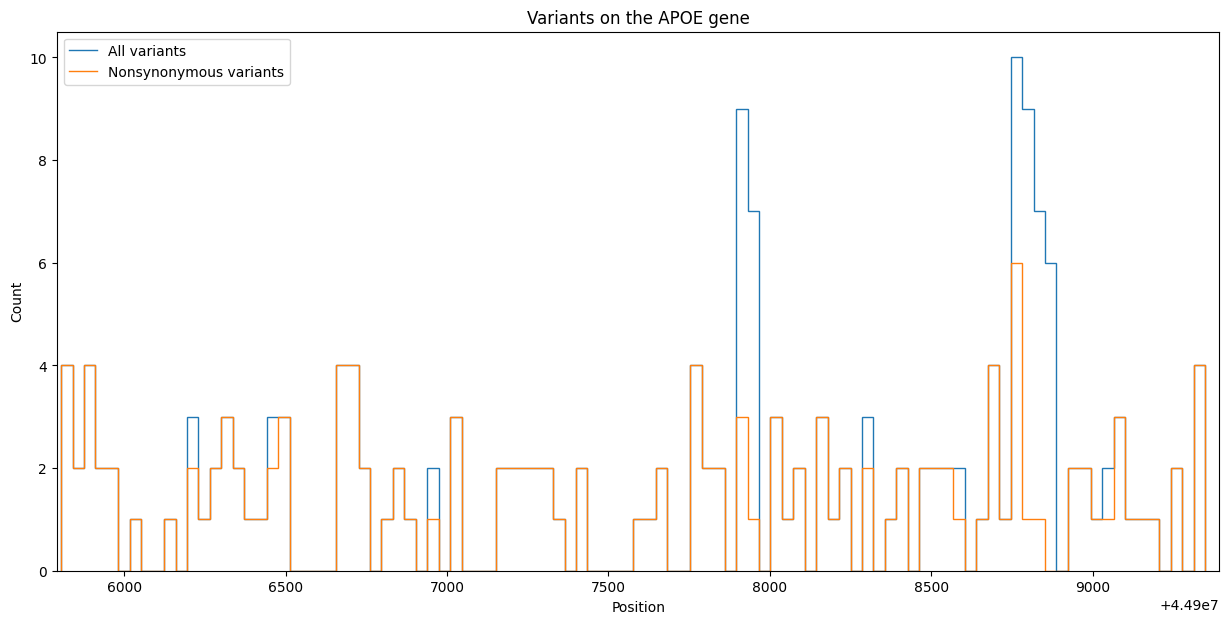

In [9]:
plt.figure(figsize=(15,7))
plt.title('Variants on the APOE gene')
# Set the bounds to the extent of the gene
plt.xlim((start, end))
plt.xlabel('Position')
plt.ylabel('Count')

plt.stairs(all_counts, all_bins, label='All variants')
plt.stairs(nonsyn_counts, nonsyn_bins, label='Nonsynonymous variants')
plt.legend()

(Probably all this really tells us is that people tend to report variants that have effects on the protein when they're on protein-coding genes!)